In [1]:
# Imports
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import scipy.stats as stats
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [ ]:
def test_term_significance(
    pre_tfidf, post_tfidf, feature_names, vocab, n_bootstrap=100, alpha=0.05
):
    """
    Test for statistical significance of changes in term frequencies

    Args:
        pre_tfidf: List of pre-ChatGPT frequencies
        post_docs: List of post-ChatGPT frequencies
        feature_names: List of feature names of the TF-IDF vectorizer
        vocab: List of terms to test
        n_bootstrap: Number of bootstrap samples
        alpha: Significance level

    Returns:
        DataFrame with significance results
    """
    # Initialize TF-IDF vectorizer
    # vectorizer = TfidfVectorizer(vocabulary=vocab)
    #
    ## Get document-term matrices
    # pre_tfidf = vectorizer.fit_transform(pre_docs)
    # post_tfidf = vectorizer.transform(post_docs)

    # Get the term indices in the vocabulary
    term_indices = {
        term: idx
        for idx, term in enumerate(
            feature_names
        )  # enumerate(vectorizer.get_feature_names_out())
    }

    results = []

    for term in tqdm(vocab):
        if term not in term_indices:
            continue

        term_idx = term_indices[term]

        # Extract term TF-IDF values for each document
        pre_term_values = pre_tfidf[:, term_idx].toarray().flatten()
        post_term_values = post_tfidf[:, term_idx].toarray().flatten()

        # Observed difference in means
        observed_diff = post_term_values.mean() - pre_term_values.mean()

        # 1. Mann-Whitney U test
        u_stat, mw_pvalue = stats.mannwhitneyu(
            post_term_values, pre_term_values, alternative="two-sided"
        )

        # 2. Permutation test
        # Combine samples
        combined = np.concatenate([pre_term_values, post_term_values])
        n_pre = len(pre_term_values)
        n_post = len(post_term_values)

        # Perform permutation test
        perm_diffs = []
        for _ in range(1000):  # Fewer permutations for speed
            np.random.shuffle(combined)
            perm_pre = combined[:n_pre]
            perm_post = combined[n_pre:]
            perm_diff = perm_post.mean() - perm_pre.mean()
            perm_diffs.append(perm_diff)

        # Calculate p-value
        perm_pvalue = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))

        # 3. Bootstrap confidence interval
        bootstrap_diffs = []
        for _ in range(n_bootstrap):
            # Resample with replacement
            boot_pre = np.random.choice(
                pre_term_values, size=len(pre_term_values), replace=True
            )
            boot_post = np.random.choice(
                post_term_values, size=len(post_term_values), replace=True
            )

            boot_diff = boot_post.mean() - boot_pre.mean()
            bootstrap_diffs.append(boot_diff)

        # Calculate 95% confidence interval
        ci_lower = np.percentile(bootstrap_diffs, 2.5)
        ci_upper = np.percentile(bootstrap_diffs, 97.5)

        # Check if CI includes zero
        ci_significant = (ci_lower > 0 and ci_upper > 0) or (
            ci_lower < 0 and ci_upper < 0
        )

        # Store results
        results.append(
            {
                "term": term,
                "pre_mean": pre_term_values.mean(),
                "post_mean": post_term_values.mean(),
                "difference": observed_diff,
                "percent_change": observed_diff / pre_term_values.mean() * 100
                if pre_term_values.mean() > 0
                else np.nan,
                "mw_pvalue": mw_pvalue,
                "perm_pvalue": perm_pvalue,
                "ci_lower": ci_lower,
                "ci_upper": ci_upper,
                "significant_05": (mw_pvalue < alpha)
                and (perm_pvalue < alpha)
                and ci_significant,
            }
        )

    return pl.DataFrame(results)

In [3]:
# Step 1: Load and prepare your lemmatized text data
# Assuming you have a dataframe with columns: 'post_id', 'date', 'lemmatized_text'
# Example of loading data (replace with your actual data loading code)
df = pl.scan_parquet("../data/batched_processing/stackoverflow_processed_batch.parquet")

# Step 2: Define pre and post-treatment periods
treatment_date = datetime(2022, 11, 30)
df = df.with_columns(
    pl.col("CreationDate").cast(pl.Datetime).lt(treatment_date).alias("pre_treatment")
)

# Step 3: Group texts by pre/post treatment
pre_texts = (
    df.filter((pl.col("pre_treatment")) & (pl.col("processed_text").is_not_null()))
    .select("processed_text")
    .collect()
)
post_texts = (
    df.filter(
        (pl.col("pre_treatment").not_()) & (pl.col("processed_text").is_not_null())
    )
    .select("processed_text")
    .collect()
)

# Convert to lists for scikit-learn
pre_texts_list = pre_texts["processed_text"].to_list()
post_texts_list = post_texts["processed_text"].to_list()

# Step 4: Create TF-IDF matrices for both periods
# You can adjust parameters based on your needs
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000,  # Consider top 5000 terms
    min_df=10,  # Ignore terms that appear in less than 10 documents
    max_df=0.7,  # Ignore terms that appear in more than 70% of documents
    ngram_range=(1, 2),  # Include unigrams and bigrams
)

# Step 5: Fit on all documents to ensure consistent vocabulary
all_texts = pre_texts_list + post_texts_list
tfidf_vectorizer.fit(all_texts)

# Step 6: Transform both pre and post text sets
pre_tfidf = tfidf_vectorizer.transform(pre_texts_list)
post_tfidf = tfidf_vectorizer.transform(post_texts_list)

In [4]:
# Step 7: Extract vocabulary and calculate mean TF-IDF scores for each period
vocabulary = tfidf_vectorizer.get_feature_names_out()
pre_mean_tfidf = np.asarray(pre_tfidf.mean(axis=0)).flatten()
post_mean_tfidf = np.asarray(post_tfidf.mean(axis=0)).flatten()

# Step 8: Create a vocabulary table with comparative statistics
vocab_table = pl.DataFrame(
    {
        "term": vocabulary,
        "pre_mean_tfidf": pre_mean_tfidf,
        "post_mean_tfidf": post_mean_tfidf,
    }
)

# Calculate differences and ratios
vocab_table = vocab_table.with_columns(
    [
        (pl.col("post_mean_tfidf") - pl.col("pre_mean_tfidf")).alias("tfidf_diff"),
        (pl.col("post_mean_tfidf") / pl.col("pre_mean_tfidf")).alias("tfidf_ratio"),
    ]
)

# Replace infinity values in ratio with a large number
vocab_table = vocab_table.with_columns(
    pl.when(pl.col("tfidf_ratio").is_infinite())
    .then(1000.0)  # Large value for terms not in pre-treatment
    .otherwise(pl.col("tfidf_ratio"))
    .alias("tfidf_ratio")
)

In [5]:
# Step 9: Calculate term frequencies (document occurrence)
pre_doc_count = len(pre_texts_list)
post_doc_count = len(post_texts_list)

pre_term_counts = (pre_tfidf > 0).sum(axis=0).A1  # Count docs containing term
post_term_counts = (post_tfidf > 0).sum(axis=0).A1

# Add frequency info to the vocabulary table
vocab_table = vocab_table.with_columns(
    [
        (pl.lit(pre_term_counts) / pre_doc_count).alias("pre_doc_freq"),
        (pl.lit(post_term_counts) / post_doc_count).alias("post_doc_freq"),
        (
            (pl.lit(post_term_counts) / post_doc_count)
            - (pl.lit(pre_term_counts) / pre_doc_count)
        ).alias("doc_freq_diff"),
    ]
)

# Step 10: Find the most distinctive terms in each period
# Terms that became more important after treatment
more_important = vocab_table.filter(pl.col("tfidf_diff") > 0).sort(
    "tfidf_diff", descending=True
)
# Terms that became less important after treatment
less_important = vocab_table.filter(pl.col("tfidf_diff") < 0).sort(
    "tfidf_diff", descending=False
)

# Step 11: Find new terms that weren't significant before
new_terms = (
    vocab_table.filter(pl.col("pre_doc_freq") < 0.01)
    .filter(pl.col("post_doc_freq") > 0.05)
    .sort("post_doc_freq", descending=True)
)
# Find terms that disappeared or significantly declined
disappeared_terms = (
    vocab_table.filter(pl.col("pre_doc_freq") > 0.05)
    .filter(pl.col("post_doc_freq") < 0.01)
    .sort("pre_doc_freq", descending=True)
)

In [6]:
# Print results
print("Top 20 terms with increased importance post-ChatGPT:")
print(more_important.head(20))

print("\nTop 20 terms with decreased importance post-ChatGPT:")
print(less_important.head(20))

print("\nTop 20 new or emerging terms post-ChatGPT:")
print(new_terms.head(20))

print("\nTop 20 disappearing terms post-ChatGPT:")
print(disappeared_terms.head(20))

Top 20 terms with increased importance post-ChatGPT:
shape: (20, 8)
┌───────────┬────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┐
│ term      ┆ pre_mean_t ┆ post_mean_ ┆ tfidf_diff ┆ tfidf_rat ┆ pre_doc_f ┆ post_doc_ ┆ doc_freq_ │
│ ---       ┆ fidf       ┆ tfidf      ┆ ---        ┆ io        ┆ req       ┆ freq      ┆ diff      │
│ str       ┆ ---        ┆ ---        ┆ f64        ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆ f64        ┆ f64        ┆            ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ try       ┆ 0.03052    ┆ 0.035374   ┆ 0.004854   ┆ 1.159055  ┆ 0.43475   ┆ 0.511423  ┆ 0.076674  │
│ error     ┆ 0.025428   ┆ 0.02913    ┆ 0.003702   ┆ 1.145596  ┆ 0.228477  ┆ 0.268945  ┆ 0.040468  │
│ issue     ┆ 0.008053   ┆ 0.011245   ┆ 0.003192   ┆ 1.396432  ┆ 0.08021   ┆ 0.115455  ┆ 0.035245  │
│ expect    ┆ 0.006197 

/tmp/ipykernel_73771/1646321928.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=to_plot_pd, x="tfidf_diff", y="term", palette="coolwarm")


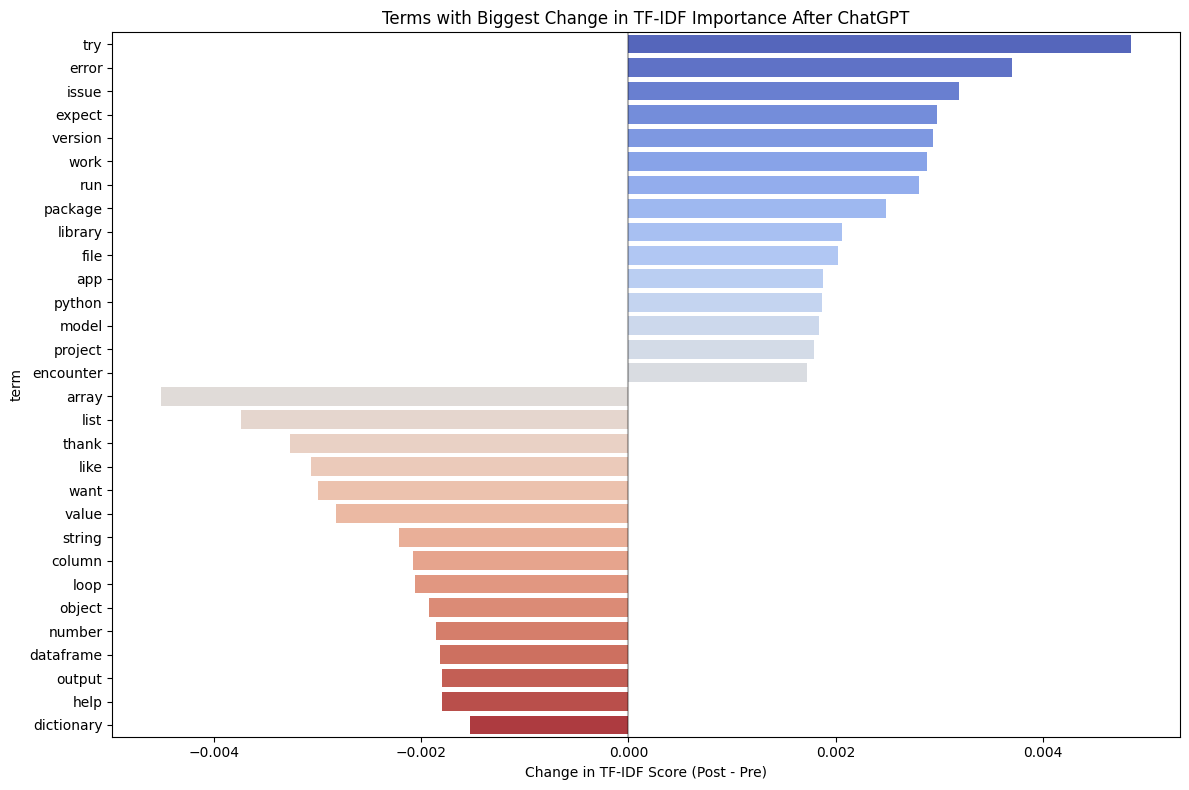

In [7]:
# Step 12: Visualize the results
plt.figure(figsize=(12, 8))
# Plot top 15 terms with biggest absolute change
top_changed = (
    vocab_table.filter(
        (pl.col("pre_doc_freq") > 0.01) | (pl.col("post_doc_freq") > 0.01)
    )
    .sort("tfidf_diff", descending=True)
    .head(15)
)

bottom_changed = (
    vocab_table.filter(
        (pl.col("pre_doc_freq") > 0.01) | (pl.col("post_doc_freq") > 0.01)
    )
    .sort("tfidf_diff", descending=False)
    .head(15)
)

# Combine for visualization
to_plot = pl.concat([top_changed, bottom_changed])

# Convert to pandas for Seaborn
to_plot_pd = to_plot.to_pandas()

# Create a barplot of the differences
sns.barplot(data=to_plot_pd, x="tfidf_diff", y="term", palette="coolwarm")
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.title("Terms with Biggest Change in TF-IDF Importance After ChatGPT")
plt.xlabel("Change in TF-IDF Score (Post - Pre)")
plt.tight_layout()
plt.savefig("../imgs/tfidf_change_plot.svg")
plt.show()

## Further analysis

/tmp/ipykernel_73771/1720025190.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


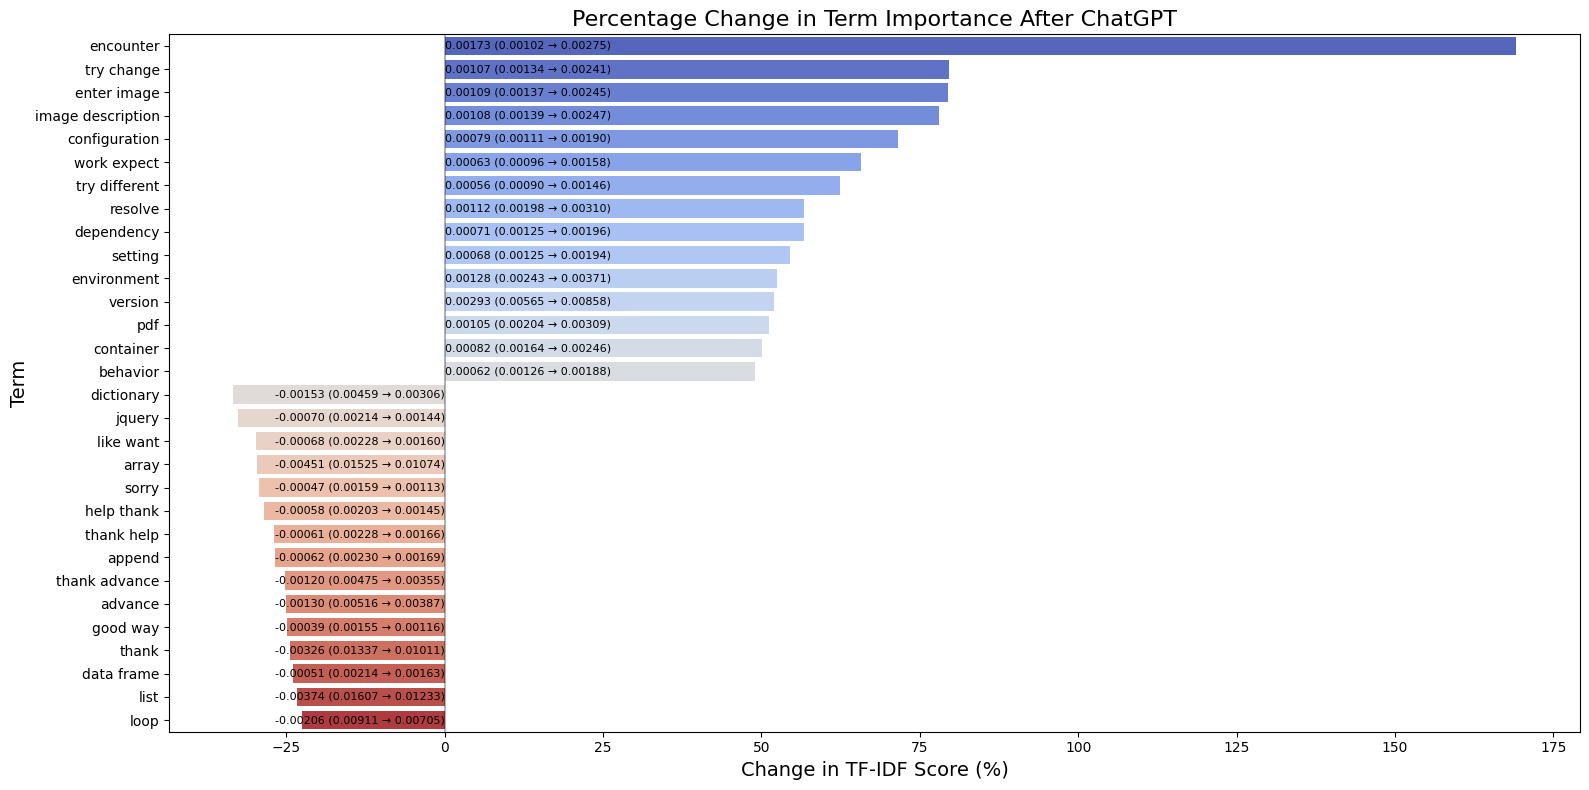

In [20]:
# Calculate percentage changes (with handling for zero/near-zero values)
vocab_table = vocab_table.with_columns(
    [
        (
            pl.when(pl.col("pre_mean_tfidf") > 0.0001)
            .then(
                (pl.col("post_mean_tfidf") - pl.col("pre_mean_tfidf"))
                / pl.col("pre_mean_tfidf")
                * 100
            )
            .otherwise(None)
        ).alias("tfidf_percent_change")
    ]
)

# Filter to terms with sufficient presence
significant_terms = vocab_table.filter(
    (pl.col("pre_doc_freq") > 0.01) | (pl.col("post_doc_freq") > 0.01)
)

# Visualize percentage changes
plt.figure(figsize=(16, 8))
top_increased = (
    significant_terms.filter(pl.col("tfidf_diff") > 0)
    .sort("tfidf_percent_change", descending=True)
    .head(15)
)
top_decreased = (
    significant_terms.filter(pl.col("tfidf_diff") < 0)
    .sort("tfidf_percent_change")
    .head(15)
)
to_plot = pl.concat([top_increased, top_decreased])

# Create a barplot with percentage changes
ax = sns.barplot(
    data=to_plot.to_pandas(),
    x="tfidf_percent_change",
    y="term",
    palette="coolwarm",
    errorbar="ci",
)

# Add absolute values as text
for i, p in enumerate(ax.patches):
    if i < len(top_increased):
        term = top_increased["term"][i]
        abs_diff = top_increased["tfidf_diff"][i]
        pre_val = top_increased["pre_mean_tfidf"][i]
        post_val = top_increased["post_mean_tfidf"][i]
    else:
        j = i - len(top_increased)
        term = top_decreased["term"][j]
        abs_diff = top_decreased["tfidf_diff"][j]
        pre_val = top_decreased["pre_mean_tfidf"][j]
        post_val = top_decreased["post_mean_tfidf"][j]

    # Add text label with absolute values
    if p.get_width() > 0:
        ax.text(
            0,
            p.get_y() + p.get_height() / 2,
            f"{abs_diff:.5f} ({pre_val:.5f} → {post_val:.5f})",
            ha="left",
            va="center",
            fontsize=8,
        )
    else:
        ax.text(
            0,
            p.get_y() + p.get_height() / 2,
            f"{abs_diff:.5f} ({pre_val:.5f} → {post_val:.5f})",
            ha="right",
            va="center",
            fontsize=8,
        )

plt.title("Percentage Change in Term Importance After ChatGPT", fontsize=16)
plt.xlabel("Change in TF-IDF Score (%)", fontsize=14)
plt.ylabel("Term", fontsize=14)
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.tight_layout()
plt.savefig("../imgs/tfidf_percent_change_plot.svg")
plt.show()

In [ ]:
print("Term frequency - statistical tests")

terms_to_test = top_changed["term"].to_list() + bottom_changed["term"].to_list()

term_stats = test_term_significance(
    pre_tfidf=pre_tfidf,
    post_tfidf=post_tfidf,
    feature_names=vocabulary,
    vocab=terms_to_test,
    n_bootstrap=100,
    alpha=0.05,
)

# Save to file
term_stats.write_parquet("../data/tfidf_term_significance.parquet")

Term frequency - statistical tests


100%|██████████| 40/40 [20:29<00:00, 30.73s/it]


In [17]:
t_stats = pl.read_parquet("../data/tfidf_term_significance.parquet")
t_stats.head()

term,pre_mean,post_mean,difference,percent_change,mw_pvalue,perm_pvalue,ci_lower,ci_upper,significant_05
str,f64,f64,f64,f64,f64,f64,f64,f64,i64
"""array""",0.015253,0.010742,-0.004511,-29.577592,8.6016e-263,0.0,-0.004692,-0.00427,1
"""list""",0.016072,0.012333,-0.003738,-23.260624,4.0911e-132,0.0,-0.003982,-0.003496,1
"""thank""",0.013372,0.010109,-0.003263,-24.40503,0.0,0.0,-0.003382,-0.003132,1
"""like""",0.026469,0.023404,-0.003065,-11.580822,2.8447e-102,0.0,-0.003221,-0.002876,1
"""want""",0.025726,0.022735,-0.002991,-11.626371,7.2817e-122,0.0,-0.00315,-0.002842,1


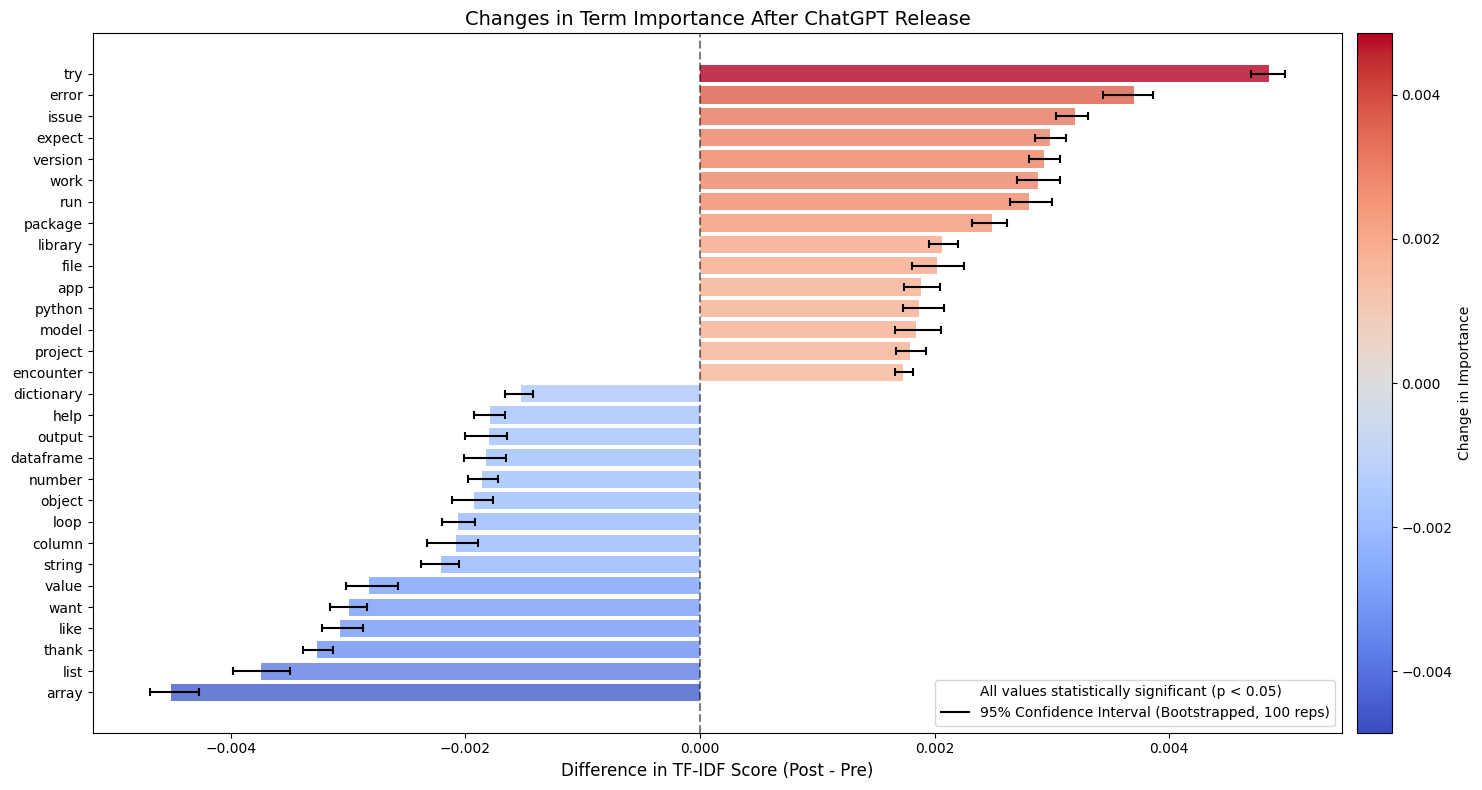

In [ ]:
top_terms = t_stats.filter(pl.col("term").is_in(terms_to_test)).sort("difference")

# Create a visualization with matplotlib
plt.figure(figsize=(16, 8))

# Create a coolwarm colormap based on difference values
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D

# Normalize difference values to range [-1, 1] for proper coolwarm mapping
norm = Normalize(
    vmin=-top_terms["difference"].abs().max(), vmax=top_terms["difference"].abs().max()
)
cmap = plt.get_cmap("coolwarm")

# Generate colors from the coolwarm palette
colors = [cmap(norm(diff)) for diff in top_terms["difference"]]

# Create horizontal bar plot
y_pos = range(len(top_terms))
bars = plt.barh(y_pos, top_terms["difference"], color=colors, alpha=0.8)

# Calculate error bar sizes
error_lower = top_terms["difference"] - top_terms["ci_lower"]
error_upper = top_terms["ci_upper"] - top_terms["difference"]

# Add error bars with plt.errorbar
plt.errorbar(
    top_terms["difference"],  # x data points
    y_pos,  # y positions
    xerr=[error_lower, error_upper],  # asymmetric error bars [lower, upper]
    fmt="none",  # no markers/lines, just error bars
    ecolor="black",  # black error bars
    capsize=3,  # size of caps at the end of error bars
    elinewidth=1.5,  # width of error bar lines
    capthick=1.5,  # thickness of cap lines
)

# Add vertical line at zero
plt.axvline(x=0, color="black", linestyle="--", alpha=0.5)

# Add y-axis labels (terms)
plt.yticks(y_pos, top_terms["term"])

# Add title and labels
plt.title("Changes in Term Importance After ChatGPT Release", fontsize=14)
plt.xlabel("Difference in TF-IDF Score (Post - Pre)", fontsize=12)

# Create a colorbar for reference
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), orientation="vertical", pad=0.01)
cbar.set_label("Change in Importance")

# Add a legend explaining the significance marker
legend_elements = [
    Line2D(
        [0],
        [0],
        marker="${*}{*}{*}$",
        color="w",
        markerfacecolor="black",
        markersize=10,
        label="All values statistically significant (p < 0.05)",
    ),
    Line2D(
        [0],
        [0],
        color="black",
        label="95% Confidence Interval (Bootstrapped, 100 reps)",
    ),
]

plt.legend(handles=legend_elements, loc="lower right")

plt.tight_layout()
plt.savefig("../imgs/term_significance_plot.svg")
plt.show()